In [ ]:
import pandas as pd
import numpy as np
from re import search
import plotly.express as px
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
xls = pd.ExcelFile('OpenBarre_QUEST_cleaned.xlsx')
fb_page_reach = pd.read_excel(xls, 'FB Page Reach')
ig_page_reach = pd.read_excel(xls, 'IG Page Reach')
fb_page_visits = pd.read_excel(xls, 'FB Page Visits')
ig_prof_visits = pd.read_excel(xls, 'IG Profile Visits')
new_fb_likes = pd.read_excel(xls, 'New FB Likes')
new_ig_followers = pd.read_excel(xls, 'New IG Followers')
ads_content_insights = pd.read_excel(xls, 'Ads Content Insights')
fb_content_insights = pd.read_excel(xls, 'FB Content Insights')
ig_content_insights = pd.read_excel(xls, 'IG Content Insights')

In [ ]:
fb_content_insights['Post time'] = pd.to_datetime(fb_content_insights['Post time'], format="%Y-%m-%dT%H:%M:%S")
fb_content_insights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Caption              470 non-null    object        
 1   Post time            476 non-null    datetime64[ns]
 2   Reach                476 non-null    int64         
 3   Likes and reactions  476 non-null    int64         
 4   Sticker taps         0 non-null      float64       
 5   Replies              0 non-null      float64       
 6   Link clicks          476 non-null    int64         
 7   Comments             476 non-null    int64         
 8   Shares               476 non-null    int64         
 9   Results              0 non-null      float64       
 10  Cost per result      1 non-null      float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 41.0+ KB


In [ ]:
col_names = ['Caption', 'Post time', 'Reach', 'Likes and reactions', 'Link clicks', 'Congrat', '@']
fb_content_insights_vstags = pd.DataFrame(columns = col_names)
fb_content_insights_vstags

for index, row in fb_content_insights.iterrows():
  curr_caption = str(row['Caption'])
  if '@' in curr_caption and ('Congrat' in curr_caption or 'congrat' in curr_caption) and '@gmail' not in curr_caption:
    fb_content_insights_vstags.loc[len(fb_content_insights_vstags.index)] = [row['Caption'], row['Post time'], row['Reach'], row['Likes and reactions'], row['Link clicks'], 1, 1]
  elif 'Congrat' in curr_caption or 'congrat' in curr_caption:
    fb_content_insights_vstags.loc[len(fb_content_insights_vstags.index)] = [row['Caption'], row['Post time'], row['Reach'], row['Likes and reactions'], row['Link clicks'], 1, 0]
  elif '@' in curr_caption and '@gmail' not in curr_caption:
    fb_content_insights_vstags.loc[len(fb_content_insights_vstags.index)] = [row['Caption'], row['Post time'], row['Reach'], row['Likes and reactions'], row['Link clicks'], 0, 1]
  else:
    fb_content_insights_vstags.loc[len(fb_content_insights_vstags.index)] = [row['Caption'], row['Post time'], row['Reach'], row['Likes and reactions'], row['Link clicks'], 0, 0]


convert_dict = {'Congrat': int,
                '@': int,
                'Reach': int,
                'Likes and reactions': int,
                'Link clicks': int}  

fb_content_insights_vstags = fb_content_insights_vstags.astype(convert_dict)
fb_content_insights_vstags




,Caption,Post time,Reach,Likes and reactions,Link clicks,Congrat,@
0,Join us at the barre for a FREE first class& \...,2021-11-03 12:13:36,98,1,0,0,0
1,The Community Director at OpenBarre is a part ...,2021-11-02 19:52:30,910,11,15,0,0
2,"SO CLOSE to bringing back those smiles, hugs, ...",2021-10-28 13:14:29,125,3,18,0,1
3,=Ø{ÜShe_x0019_ s baaaaaack! We_x0019_ ve been ...,2021-10-24 13:54:07,286,13,9,0,0
4,"T'who_x0019_ s an OpenBarre class for, really?...",2021-10-19 06:05:37,948,7,16,0,0
...,...,...,...,...,...,...,...
471,HUGE congrats to Beth Giunta for 200 classes w...,2018-10-13 07:30:37,509,84,189,1,0
472,"Tickets are non-refundable, but can be transf...",2018-10-10 07:55:57,0,5,0,0,0
473,"WeWork freebies at OpenBarre this Friday, 10/1...",2018-10-09 17:09:36,0,0,0,0,0
474,It's day one of #sundayscaries at OpenBarre! T...,2018-10-07 09:35:40,0,5,0,0,0


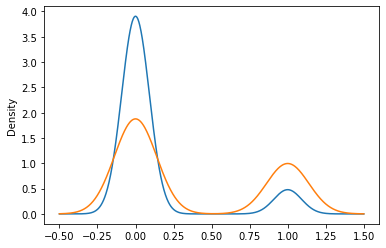

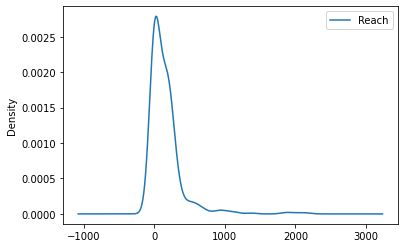

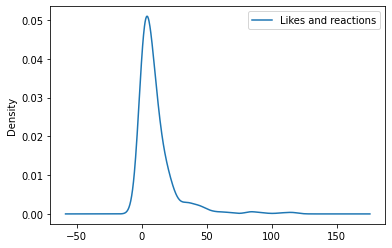

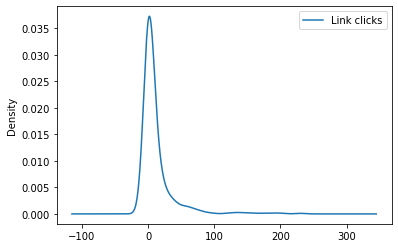

In [ ]:
fb_content_insights_vstags['Congrat'].plot.kde()
fb_content_insights_vstags['@'].plot.kde()
fb_content_insights_vstags[['Reach']].plot.kde()
fb_content_insights_vstags[['Likes and reactions']].plot.kde()
fb_content_insights_vstags[['Link clicks']].plot.kde()

fb_content_insights_vstags['ln_Congrat'] = np.log(fb_content_insights_vstags['Congrat'] + 1)
fb_content_insights_vstags['ln_@'] = np.log(fb_content_insights_vstags['@'] + 1)
fb_content_insights_vstags['ln_Reach'] = np.log(fb_content_insights_vstags['Reach'] + 1)
fb_content_insights_vstags['ln_Likes and reactions'] = np.log(fb_content_insights_vstags['Likes and reactions'] + 1)
fb_content_insights_vstags['ln_Link clicks'] = np.log(fb_content_insights_vstags['Link clicks'] + 1)


In [ ]:
# OLS Congrat vs Reach
YVar = fb_content_insights_vstags[['ln_Reach']]
XVar = fb_content_insights_vstags[['ln_Congrat']]
XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Reach   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     16.51
Date:                Sun, 01 May 2022   Prob (F-statistic):           5.65e-05
Time:                        20:45:05   Log-Likelihood:                -1116.5
No. Observations:                 476   AIC:                             2237.
Df Residuals:                     474   BIC:                             2245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0771      0.123     25.028      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS @ vs Reach
YVar = fb_content_insights_vstags[['Reach']]
XVar = fb_content_insights_vstags[['ln_@']]
XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                            OLS Regression Results                            
Dep. Variable:                  Reach   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.609
Date:                Sun, 01 May 2022   Prob (F-statistic):              0.107
Time:                        20:45:32   Log-Likelihood:                -3311.7
No. Observations:                 476   AIC:                             6627.
Df Residuals:                     474   BIC:                             6636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        171.0418     14.449     11.838      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS Congrat and @ vs Reach
ind_var_arr = ['ln_Congrat', 'ln_@']
XVar = fb_content_insights_vstags[ind_var_arr]
YVar = fb_content_insights_vstags[['ln_Reach']]
XVar.corr()

XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Reach   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     8.240
Date:                Sun, 01 May 2022   Prob (F-statistic):           0.000304
Time:                        20:46:18   Log-Likelihood:                -1116.5
No. Observations:                 476   AIC:                             2239.
Df Residuals:                     473   BIC:                             2252.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0762      0.152     20.191      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS Congrat vs Likes and reactions
YVar = fb_content_insights_vstags[['ln_Likes and reactions']]
XVar = fb_content_insights_vstags[['ln_Congrat']]
XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                              OLS Regression Results                              
Dep. Variable:     ln_Likes and reactions   R-squared:                       0.049
Model:                                OLS   Adj. R-squared:                  0.047
Method:                     Least Squares   F-statistic:                     24.63
Date:                    Sun, 01 May 2022   Prob (F-statistic):           9.72e-07
Time:                            20:46:36   Log-Likelihood:                -690.13
No. Observations:                     476   AIC:                             1384.
Df Residuals:                         474   BIC:                             1393.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS @ vs Likes and reactions
YVar = fb_content_insights_vstags[['ln_Likes and reactions']]
XVar = fb_content_insights_vstags[['ln_@']]
XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                              OLS Regression Results                              
Dep. Variable:     ln_Likes and reactions   R-squared:                       0.003
Model:                                OLS   Adj. R-squared:                  0.001
Method:                     Least Squares   F-statistic:                     1.569
Date:                    Sun, 01 May 2022   Prob (F-statistic):              0.211
Time:                            20:46:54   Log-Likelihood:                -701.40
No. Observations:                     476   AIC:                             1407.
Df Residuals:                         474   BIC:                             1415.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS Congrat and @ vs Likes and reactions
ind_var_arr = ['ln_Congrat', 'ln_@']
XVar = fb_content_insights_vstags[ind_var_arr]
XVar.corr()
YVar = fb_content_insights_vstags[['ln_Likes and reactions']]

XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                              OLS Regression Results                              
Dep. Variable:     ln_Likes and reactions   R-squared:                       0.056
Model:                                OLS   Adj. R-squared:                  0.052
Method:                     Least Squares   F-statistic:                     14.11
Date:                    Fri, 22 Apr 2022   Prob (F-statistic):           1.11e-06
Time:                            18:58:37   Log-Likelihood:                -688.39
No. Observations:                     476   AIC:                             1383.
Df Residuals:                         473   BIC:                             1395.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS Congrat vs Link clicks
YVar = fb_content_insights_vstags[['ln_Link clicks']]
XVar = fb_content_insights_vstags[['ln_Congrat']]
XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_Link clicks   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     16.66
Date:                Sun, 01 May 2022   Prob (F-statistic):           5.25e-05
Time:                        20:47:11   Log-Likelihood:                -847.48
No. Observations:                 476   AIC:                             1699.
Df Residuals:                     474   BIC:                             1707.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2536      0.070     17.945      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS @ vs Link clicks
YVar = fb_content_insights_vstags[['ln_Link clicks']]
XVar = fb_content_insights_vstags[['ln_@']]
XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_Link clicks   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.594
Date:                Fri, 22 Apr 2022   Prob (F-statistic):              0.108
Time:                        19:02:54   Log-Likelihood:                -854.41
No. Observations:                 476   AIC:                             1713.
Df Residuals:                     474   BIC:                             1721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4263      0.083     17.234      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# OLS Congrat and @ vs Link clicks
ind_var_arr = ['ln_Congrat', 'ln_@']
XVar = fb_content_insights_vstags[ind_var_arr]
XVar.corr()
YVar = fb_content_insights_vstags[['ln_Link clicks']]

XVar = sm.add_constant(XVar)
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_Link clicks   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     9.031
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           0.000142
Time:                        19:06:02   Log-Likelihood:                -846.79
No. Observations:                 476   AIC:                             1700.
Df Residuals:                     473   BIC:                             1712.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3137      0.086     15.197      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


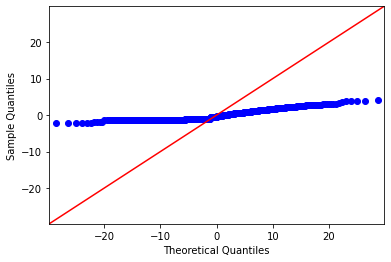

In [ ]:
residuals = LinearModel.resid
sm.qqplot(residuals, scale=10, line='45')
plt.show()

In [ ]:
# 

In [ ]:
# sent = ['it was a good movie', 'this movie was bad', 'what a great movie', 'wow, what a shitty movie']

# fb_content_insights_vstags['Caption']
# cv = CountVectorizer(
#     min_df = 2,
#     max_df = 0.9,
#     stop_words = 'english'
# )

# cv.fit(sent)
# word_sentence_matrix = cv.transform(sent)
# sent_df = pd.DataFrame(word_sentence_matrix.toarray(), columns = cv.get_feature_names())
# sent_df

In [ ]:
# having posts with a 'congrats' is positively correlated with higher reach
# even more so with higher likes and reactions
# and around the same as reach for link clicks 